We are going to create a grid of model maps and compare the data to the maps, so that we can see what the distribution in $\Delta \chi^2_\nu$ looks like throughout the parameter space.

In [11]:
import numpy as np
import numpy.ma as ma

from astropy.table import QTable

import sys
sys.path.insert(1,"/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/")
from DRP_rotation_curve import extract_data
from DRP_vel_map_functions import model_vel_map, deproject_spaxel, calculate_chi2

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Galaxy data

In [2]:
MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/dr16/manga/spectro/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'

In [3]:
gal_ID = '7443-12705'
#gal_ID = '8486-12701'

manga_plate, manga_IFU = gal_ID.split('-')
gal_filename = VEL_MAP_FOLDER + manga_plate + '/' + manga_IFU + '/manga-' + gal_ID + '-MAPS-HYB10-GAU-MILESHC.fits.gz'

In [4]:
Ha_vel, Ha_vel_ivar, Ha_vel_mask, r_band, r_band_ivar = extract_data(gal_filename)

mr_band = ma.array(r_band, mask=Ha_vel_mask)
mHa_vel = ma.array(Ha_vel, mask=Ha_vel_mask)
mHa_vel_ivar = ma.array(Ha_vel_ivar, mask=Ha_vel_mask)

In [5]:
map_shape = mHa_vel.shape

In [6]:
oneD_fit_file = '../spirals/DRPall-master_file_30.txt'

oneD_fit_parameters = QTable.read(oneD_fit_file, format='ascii.ecsv')

gal_oneD_fit_parameters_boolean = np.logical_and(oneD_fit_parameters['MaNGA_plate'] == int(manga_plate), 
                                                 oneD_fit_parameters['MaNGA_IFU'] == int(manga_IFU))

gal_oneD_fit_parameters_row = oneD_fit_parameters[gal_oneD_fit_parameters_boolean]

In [7]:
i_angle = np.arccos(gal_oneD_fit_parameters_row['ba'][0])
center = np.unravel_index(ma.argmax(mr_band), mr_band.shape)
v_sys = mHa_vel[center]
phi = gal_oneD_fit_parameters_row['phi'][0].value*np.pi/180
#v_max = gal_oneD_fit_parameters_row['avg_v_max'][0].value
#r_turn = gal_oneD_fit_parameters_row['avg_r_turn'][0].value
#alpha = gal_oneD_fit_parameters_row['avg_alpha'][0]

# Find spaxel along semi-major axis
delta_x = int(center[1]*0.5)
delta_y = int(delta_x/np.tan(phi))
semi_major_axis_spaxel = tuple(np.subtract(center, (-delta_y, delta_x)))

# Check value along semi-major axis
if mHa_vel[semi_major_axis_spaxel] < 0:
    phi_guess = phi + np.pi
else:
    phi_guess = phi

pos_params = [v_sys, i_angle, center[0], center[1], phi_guess]
#vel_params = [v_max, r_turn, alpha]
#best_fit_params = pos_params + vel_params
'''
best_fit_values = {'v_sys':v_sys,
                   'ba':gal_oneD_fit_parameters_row['ba'][0],
                   'x0':center[0],
                   'y0':center[1],
                   'phi':phi_guess,
                   'r_turn':r_turn,
                   'v_max':v_max,
                   'alpha':alpha}
''';

In [8]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

MANGA_FIBER_DIAMETER = 2*(1/60)*(1/60)*(np.pi/180) # angular fiber diameter (2") in radians
MANGA_SPAXEL_SIZE = 0.5*(1/60)*(1/60)*(np.pi/180)  # spaxel size (0.5") in radians


dist_to_galaxy_Mpc = c*gal_oneD_fit_parameters_row['redshift'][0]/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

pix_scale_factor = dist_to_galaxy_kpc*np.tan(MANGA_SPAXEL_SIZE)

# Build array of $\Delta \chi^2_\nu$ for model velocity maps

In [52]:
# Maximum velocity [km/s]
v_max_low = 100
v_max_high = 4100
v_max_values = np.arange(v_max_low, v_max_high, 10)
N_v_max = len(v_max_values)

# Turn radius [kpc]
r_turn_scale = 1 # Used to scale r_turn up so that it is more similar to v_max
r_turn_low = 0.5*r_turn_scale
r_turn_high = 100*r_turn_scale
r_turn_values = np.arange(r_turn_low, r_turn_high, 5)
N_r_turn = len(r_turn_values)

# Alpha
alpha_scale = 1 # Used to scale alpha up so that it is more similar to the other fit parameters
alpha_low = 0.001*alpha_scale
alpha_high = 10*alpha_scale
N_alpha = 10
alpha_values = np.logspace(-3,1,N_alpha)

In [53]:
chi2 = np.zeros((N_v_max, N_r_turn, N_alpha))

for i in range(N_v_max):
    for j in range(N_r_turn):
        for k in range(N_alpha):
            chi2[i,j,k] = calculate_chi2(np.concatenate([pos_params, [v_max_values[i], 
                                                                      r_turn_values[j],
                                                                      alpha_values[k]]]),
                                         mHa_vel, 
                                         mHa_vel_ivar,
                                         pix_scale_factor,
                                         'BB', 
                                         alpha_scale,
                                         r_turn_scale)

KeyboardInterrupt: 

## Find minimum of $\Delta \chi^2_\nu$

In [36]:
index = np.unravel_index(np.argmin(chi2), chi2.shape)

v_max_min = v_max_values[index[0]]
r_turn_min = r_turn_values[index[1]]
alpha_min = alpha_values[index[2]]

print('V_max:', v_max_min)
print('R_turn:', r_turn_min)
print('alpha:', alpha_min)
print('chi2:', chi2[index])

V_max: 3860
R_turn: 0.5
alpha: 0.1668100537200059
chi2: 159.43673613286848


## Visualization of $\Delta \chi^2_\nu$

In [12]:
v_max_grid, r_turn_grid, alpha_grid = np.meshgrid(v_max_values, r_turn_values, alpha_values)

<IPython.core.display.Javascript object>


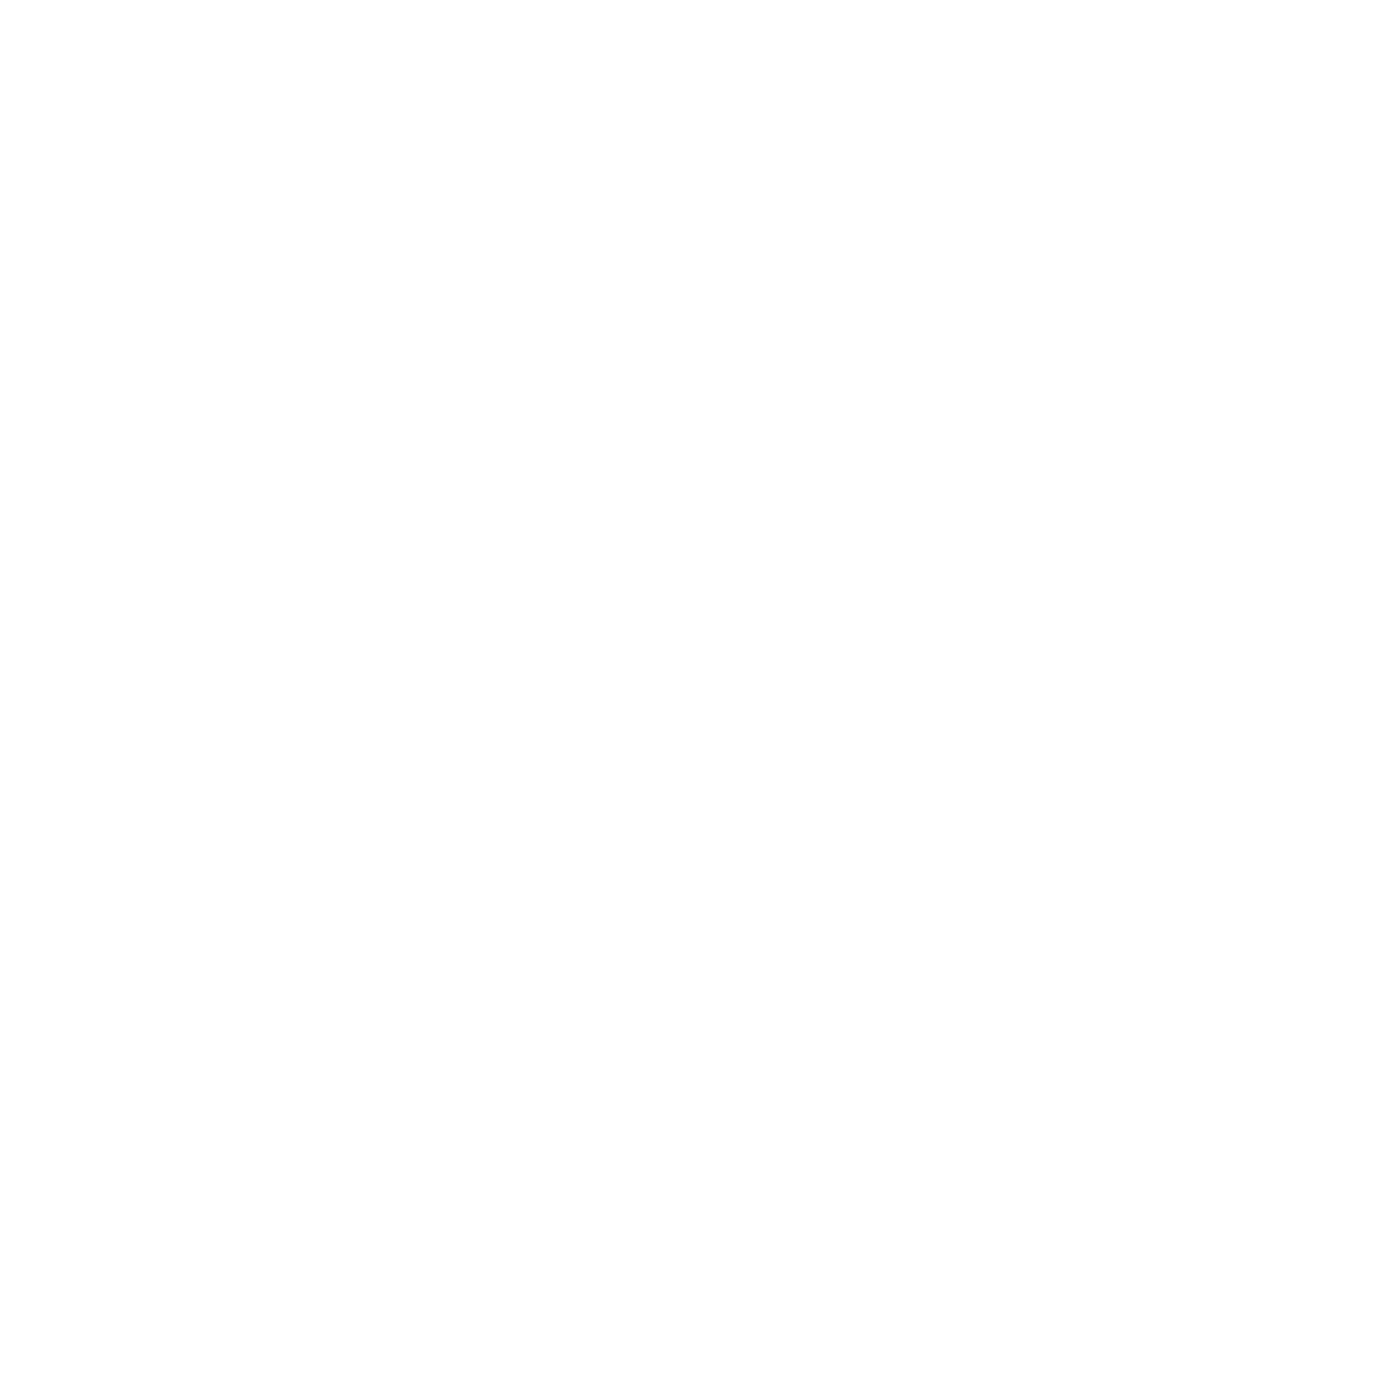

<ipython-input-54-d4ae33880238>:4: RuntimeWarning: divide by zero encountered in log10
  p = ax.scatter(v_max_grid, r_turn_grid, np.log10(alpha_grid), c=np.log10(chi2), cmap='cool', s=1)


ValueError: 'c' argument has 80000 elements, which is inconsistent with 'x' and 'y' with size 16400.

In [54]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(v_max_grid, r_turn_grid, np.log10(alpha_grid), c=np.log10(chi2), cmap='cool', s=1)
ax.scatter(402.032, 1.396, np.log10(0.507), c='r', marker='*')
ax.scatter(316.97, 2.25, np.log10(0.85), c='r')
ax.scatter(264.98, 3.59, np.log10(1.329), c='r', marker='x')
ax.scatter(v_max_min, r_turn_min, np.log10(alpha_min), c='g')

ax.set_xlabel('$V_{max}$')
ax.set_ylabel('$R_{turn}$')
ax.set_zlabel(r'$\alpha$');

#ax.set_zscale('log')

#plt.colorbar(p);

<IPython.core.display.Javascript object>


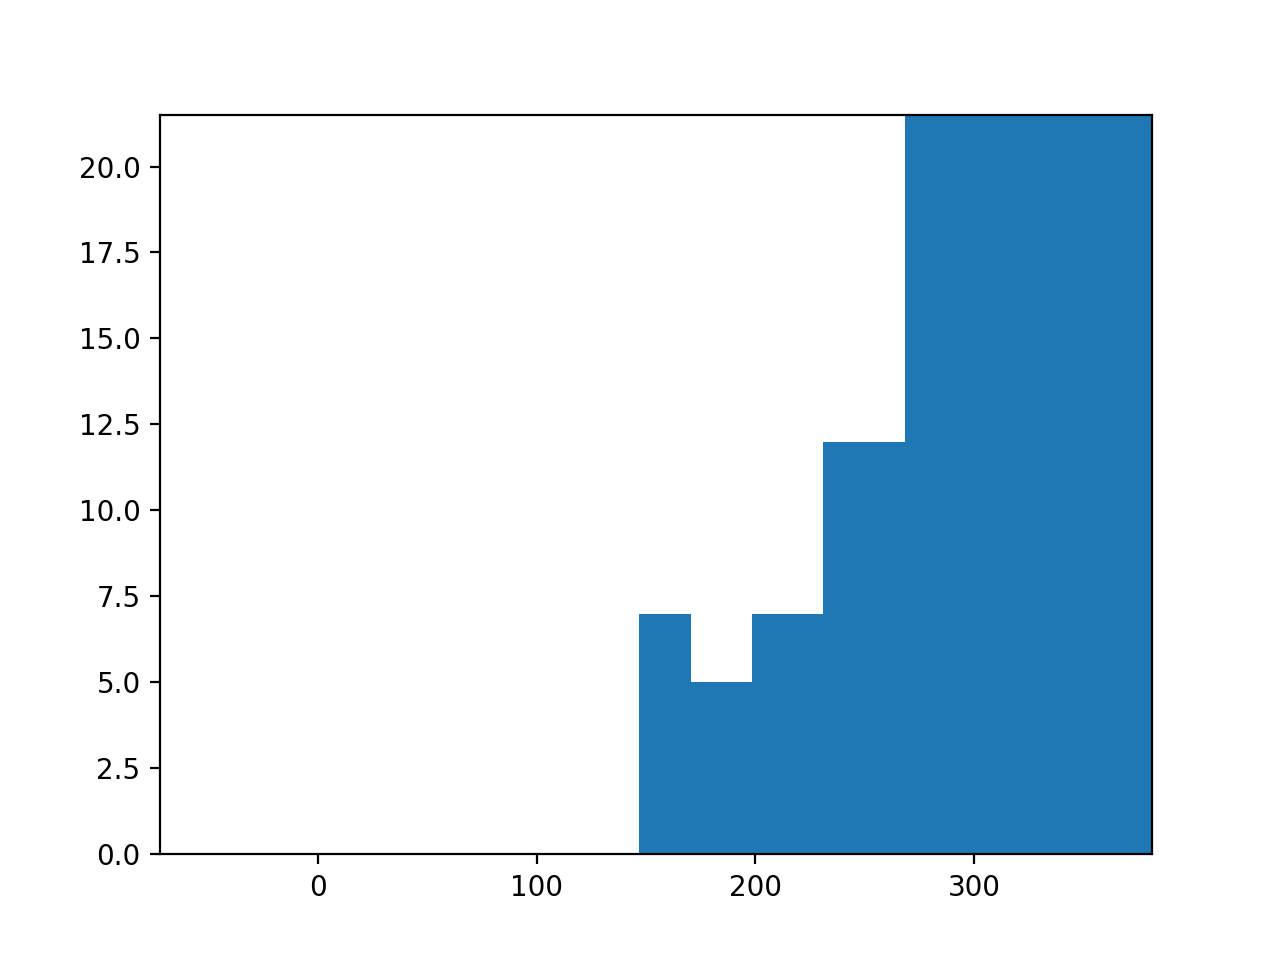

In [43]:
plt.figure()

plt.hist(chi2.flatten(), bins=np.logspace(0,6.5,100))

plt.ylim(ymax=1250);